# Cardiopatias Congenitas

In [9]:
simplificador = False# Se o simplificador = True o projeto irá recuperar checkpoints dos dados processados fazendo com que seja mais rápido rodar o notebook
seed =  42 # Semente
no_anomalies_proportion = 1 #Proporção de não anomalias em relação as anomalias

## Variaveis de Interesse 

In [2]:
target_anomalies = ['Q20','Q21','Q22','Q23','Q24','Q25','Q26''Q27','Q28']
target_years = list(range(2010,2020))
target_states = ['SP','RJ','ES','MG']

## Importing Libs

In [3]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append(os.path.join(os.path.abspath(os.getcwd()).replace('= ',''),'..'))
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import PipelineProfiler
import multiprocessing
import autosklearn.classification
from collections import Counter
#from imblearn.under_sampling import ClusterCentroids
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from src.features.feature_selection import Feature_Selection
from src.features.feature_engineering import Feature_Engineering
from src.visualization.visualize import Visualizer
from src.data.retrievers import SINASC_Retriever
from src.data.explorer import GraphExplorer
from src.io_utils import IO_Utils

/l/disk0/msasso/.local/lib/python3.8/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


In [4]:
root_dir = os.path.join(os.path.abspath(os.getcwd()).replace('= ',''),'..')
data_dir = os.path.join(root_dir,'data')
small_data_dir  = os.path.join(root_dir,'small_data')
processed_data_dir = os.path.join(data_dir,'processed')

In [5]:
%load_ext autoreload
%autoreload 2
retriever = SINASC_Retriever()
fe = Feature_Engineering()
fs = Feature_Selection()
io_utils = IO_Utils()
ge = GraphExplorer()
vi = Visualizer()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Baixando os dados do SINASC - DATASUS

In [6]:
if not simplificador:
    retriever.get_data(states=target_states,years=target_years)

## Criando dados rotulados na coleta

In [10]:
if not simplificador:
    df_anomalies = retriever.extract_rows_anomalie(states=target_states,
                            years=target_years,
                            anomalie_codes=target_anomalies,
                            anomalies_present=True)
    io_utils.save_df_zipped_csv(df=df_anomalies,dirpath=processed_data_dir,file_name='df_cardiopatias_congenitas')

    df_no_anomalies = retriever.extract_rows_anomalie(states=target_states,
                                                    years=target_years,
                                                    anomalie_codes=target_anomalies,
                                                    anomalies_present=False)
    io_utils.save_df_zipped_csv(df=df_no_anomalies,dirpath=processed_data_dir,file_name='df_no_cardiopatias_congenitas')

    df_no_anomalies_cropped = df_no_anomalies.sample(frac=1)[:len(df_anomalies)*no_anomalies_proportion].reset_index(drop=True)
    io_utils.save_df_zipped_csv(df=df_no_anomalies_cropped,dirpath=processed_data_dir,file_name='df_no_sindrome_down_cropped')
    df = pd.concat([df_anomalies,df_no_anomalies_cropped], ignore_index=True).sample(frac=1,random_state=seed).reset_index(drop=True)
    df = df.drop(['IDADEPAI','CODANOMAL', 'STATE', 'YEAR','CONTADOR'],axis = 1)

/l/disk0/msasso/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/l/disk0/msasso/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/l/disk0/msasso/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/l/disk0/msasso/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Recuperando dados rotulados na coleta

In [11]:
if simplificador:
    df_anomalies = io_utils.read_zipped_csv_df(dirpath=processed_data_dir,file_name='df_sindrome_down')
    df_anomalies['ANOMAL_PRESENT'] = 1
    df_no_anomalies = io_utils.read_zipped_csv_df(dirpath=processed_data_dir,file_name='df_no_sindrome_down')
    df_no_anomalies_cropped = df_no_anomalies.sample(frac=1)[:len(df_anomalies)*no_anomalies_proportion].reset_index(drop=True)
    #df_no_anomalies_cropped = io_utils.read_zipped_csv_df(dirpath=processed_data_dir,file_name='df_no_sindrome_down_cropped')
    df_no_anomalies_cropped['ANOMAL_PRESENT'] = 0
    df = pd.concat([df_anomalies,df_no_anomalies_cropped], ignore_index=True).sample(frac=1).reset_index(drop=True)
    df = df.drop(['IDADEPAI','CODANOMAL', 'STATE', 'YEAR','CONTADOR'],axis = 1)

## Exploração dos dados brutos

array([[<AxesSubplot:title={'center':'IDADEMAE'}>,
        <AxesSubplot:title={'center':'ESTCIVMAE'}>,
        <AxesSubplot:title={'center':'ESCMAE'}>,
        <AxesSubplot:title={'center':'QTDFILVIVO'}>,
        <AxesSubplot:title={'center':'QTDFILMORT'}>],
       [<AxesSubplot:title={'center':'GESTACAO'}>,
        <AxesSubplot:title={'center':'GRAVIDEZ'}>,
        <AxesSubplot:title={'center':'PARTO'}>,
        <AxesSubplot:title={'center':'CONSULTAS'}>,
        <AxesSubplot:title={'center':'SEXO'}>],
       [<AxesSubplot:title={'center':'APGAR1'}>,
        <AxesSubplot:title={'center':'APGAR5'}>,
        <AxesSubplot:title={'center':'RACACOR'}>,
        <AxesSubplot:title={'center':'PESO'}>,
        <AxesSubplot:title={'center':'RACACORMAE'}>],
       [<AxesSubplot:title={'center':'QTDGESTANT'}>,
        <AxesSubplot:title={'center':'QTDPARTNOR'}>,
        <AxesSubplot:title={'center':'QTDPARTCES'}>,
        <AxesSubplot:title={'center':'SEMAGESTAC'}>,
        <AxesSubplot:title={'c

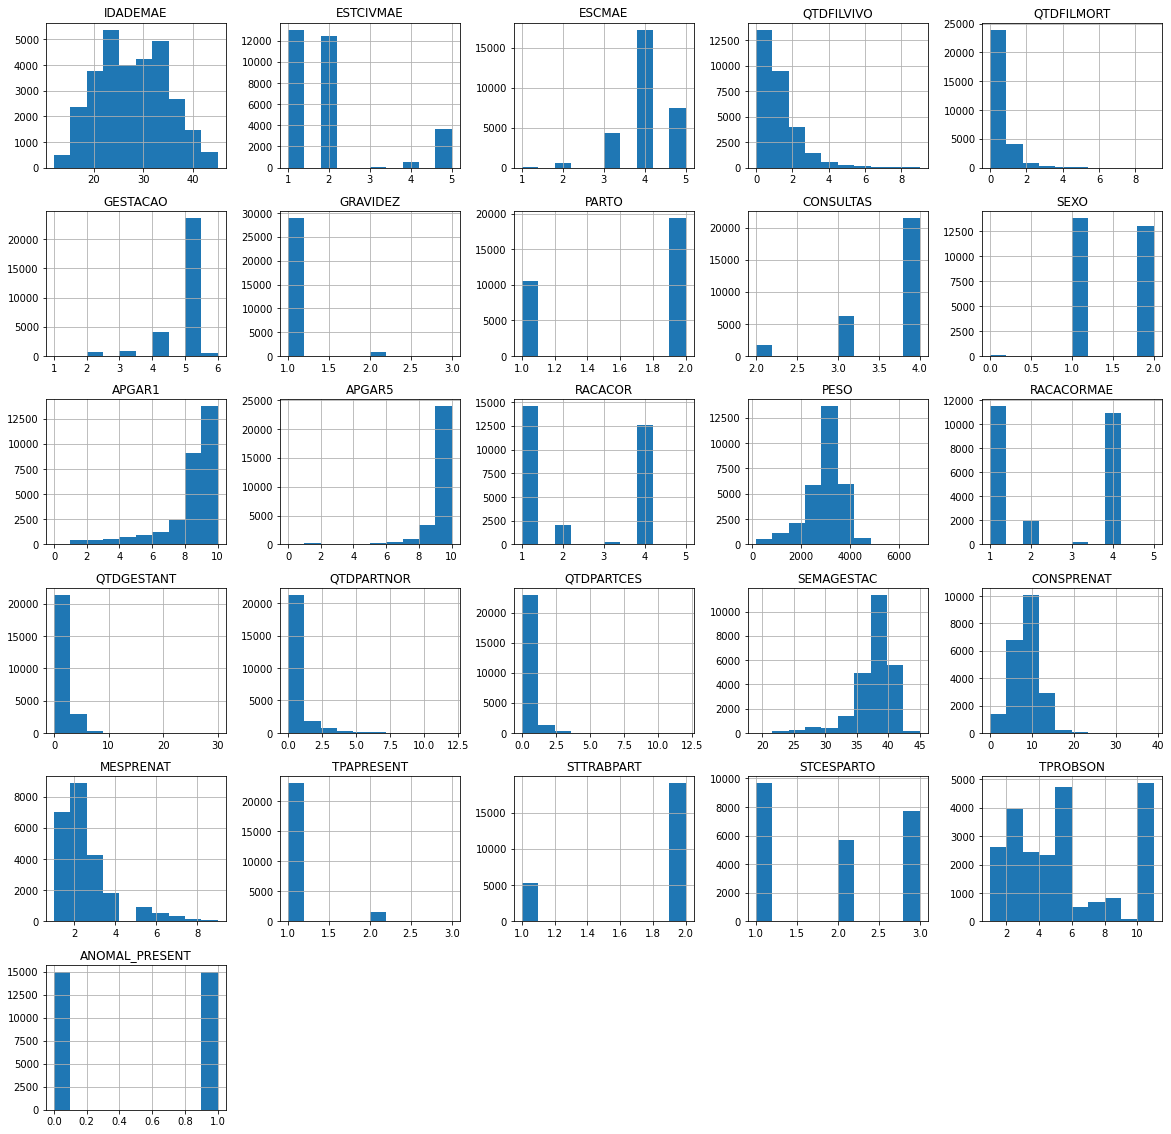

In [12]:
df.hist(figsize = (20,20))

## Engenharia de Features e Seleção Features

Separando Valores Categóricos de Numéricos para processamento diferentes

In [13]:
df = retriever.map_columns_as_categoricals(df)
df_cats = df.select_dtypes(['category'])
df_consts = df[[x for x in df.columns if x not in df_cats.columns]] 

Inputar nos valores NaN

In [14]:
df_cats_imp = fe.max_freq_inputer(df_cats)
df_consts_imp = fe.iterative_inputer_integer(df_consts)
df_cats_imp_codes = fe.get_cat_columns_in_codes(df_cats_imp)
df_hist = df_cats_imp_codes.join(df_consts_imp)

array([[<AxesSubplot:title={'center':'ESTCIVMAE'}>,
        <AxesSubplot:title={'center':'ESCMAE'}>,
        <AxesSubplot:title={'center':'GESTACAO'}>,
        <AxesSubplot:title={'center':'GRAVIDEZ'}>,
        <AxesSubplot:title={'center':'PARTO'}>],
       [<AxesSubplot:title={'center':'CONSULTAS'}>,
        <AxesSubplot:title={'center':'SEXO'}>,
        <AxesSubplot:title={'center':'RACACOR'}>,
        <AxesSubplot:title={'center':'RACACORMAE'}>,
        <AxesSubplot:title={'center':'TPAPRESENT'}>],
       [<AxesSubplot:title={'center':'STTRABPART'}>,
        <AxesSubplot:title={'center':'STCESPARTO'}>,
        <AxesSubplot:title={'center':'TPROBSON'}>,
        <AxesSubplot:title={'center':'IDADEMAE'}>,
        <AxesSubplot:title={'center':'QTDFILVIVO'}>],
       [<AxesSubplot:title={'center':'QTDFILMORT'}>,
        <AxesSubplot:title={'center':'APGAR1'}>,
        <AxesSubplot:title={'center':'APGAR5'}>,
        <AxesSubplot:title={'center':'PESO'}>,
        <AxesSubplot:title={'cen

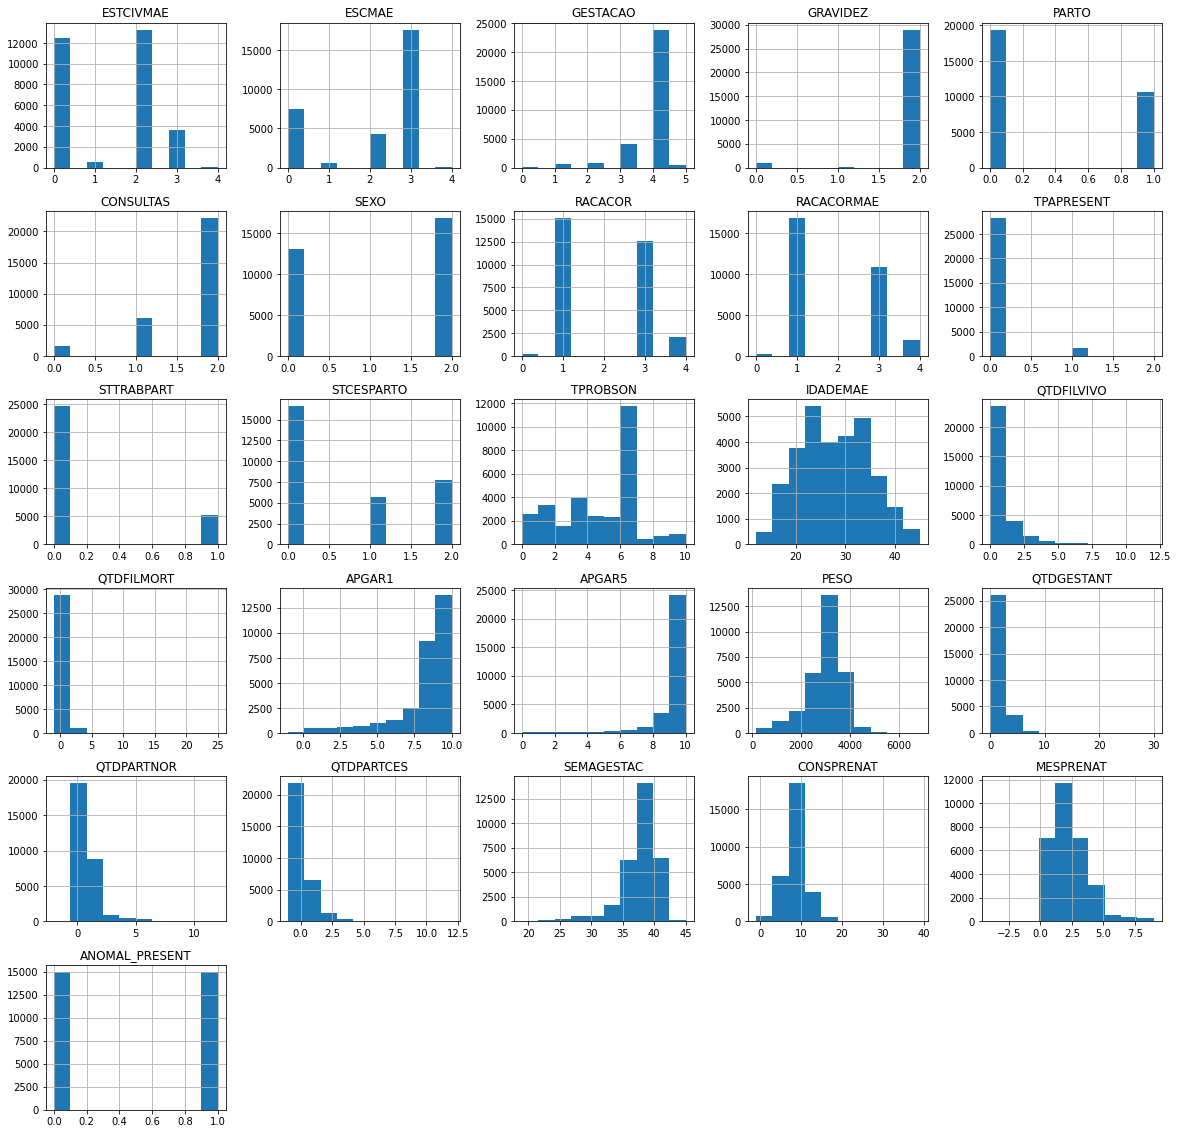

In [15]:
df_hist.hist(figsize = (20,20))

One Hot encoding nas colunas categóricas

In [16]:
df_cats_imp = fe.one_hot_encode_columns(df_cats_imp,df_cats_imp.columns)
df_cats_imp = fe.fill_categorical_no_present_classes(df_cats_imp)
df_cats_imp.head()

Casado  Separado_Judicial  Solteiro  Uniao_Estavel  Viuvo  12_+_esc  \
0       0                  0         1              0      0         0   
1       1                  0         0              0      0         0   
2       1                  0         0              0      0         1   
3       1                  0         0              0      0         1   
4       1                  0         0              0      0         1   

   1_3_esc  4_7_esc  8_11_esc  sem_esc  ...  robson_11  robson_2  robson_3  \
0        0        1         0        0  ...          0         0         0   
1        0        0         1        0  ...          0         0         0   
2        0        0         0        0  ...          0         0         0   
3        0        0         0        0  ...          1         0         0   
4        0        0         0        0  ...          0         0         0   

   robson_4  robson_5  robson_6  robson_7  robson_8  robson_9  \
0         0         0         0         0         0         0   
1         0         1         0         0         0         0   
2         0         0         0         0         0         0   
3         0         0         0         0         0         0   
4         0         1         0         0         0         0   

   sttrabpart_naplica  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  

[5 rows x 57 columns]


Recuperando dataframe processado final

In [17]:
df_processed = df_cats_imp.join(df_consts_imp)
df_processed.head()

Casado  Separado_Judicial  Solteiro  Uniao_Estavel  Viuvo  12_+_esc  \
0       0                  0         1              0      0         0   
1       1                  0         0              0      0         0   
2       1                  0         0              0      0         1   
3       1                  0         0              0      0         1   
4       1                  0         0              0      0         1   

   1_3_esc  4_7_esc  8_11_esc  sem_esc  ...  APGAR1  APGAR5  PESO  QTDGESTANT  \
0        0        1         0        0  ...       8       9  2830           0   
1        0        0         1        0  ...       9      10  3160           1   
2        0        0         0        0  ...       3       4  2050           1   
3        0        0         0        0  ...       9      10  3435           0   
4        0        0         0        0  ...      10      10  3320           1   

   QTDPARTNOR  QTDPARTCES  SEMAGESTAC  CONSPRENAT  MESPRENAT  ANOMAL_PRESENT  
0           0           0          40           8          2               0  
1           0           1          39           6          6               0  
2           0           1          28          10          1               1  
3           0           0          39          11          2               1  
4           0           0          39          11          1               0  

[5 rows x 70 columns]

## Separação em conjunto de treino e teste

In [18]:
X,y = fe._split_df_in_xy(df_processed,target_column='ANOMAL_PRESENT')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## Normalização (Usada apenas em modelos em que ela melhora a eficiência)

In [19]:
scaler = fe.fit_normalizer(df_train=X_train ,normalization_strategy='min_max_scaler')
X_train_norm = fe.normalize_data(X_train,scaler)
X_test_norm = fe.normalize_data(X_test,scaler)

## Random Forest Model
Não usa normalização

Validação Cruzada

In [20]:
clf_val = make_pipeline(RandomForestClassifier(max_depth=20, random_state=0,max_features='log2'))
scores = cross_val_score(clf_val, X_train, y_train, cv=10)
print(scores)

[0.73822426 0.75531471 0.72780325 0.74239266 0.74854045 0.74687239
 0.74437031 0.74770642 0.75854879 0.73394495]


### Treinando o Modelo


In [21]:
clf = RandomForestClassifier(max_depth=20, random_state=42,max_features='log2')#clf.fit(X_train_norm, y_train_resampled.replace({0:1,1:0}))
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features='log2', random_state=42)

### Predizendo Conjunto de Teste

In [22]:
y_pred = clf.predict(X_test)

### Extraindo Métricas

Relatório de Classificação

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      3033
           1       0.73      0.73      0.73      2963

    accuracy                           0.74      5996
   macro avg       0.74      0.74      0.74      5996
weighted avg       0.74      0.74      0.74      5996



Curva ROC

<AxesSubplot:title={'center':'Curva ROC'}, xlabel='Taxa de Falso Positivo', ylabel='Taxa de Verdadeiro Positivo'>

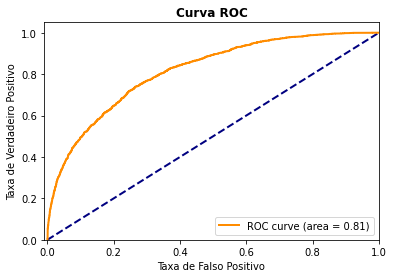

In [24]:
y_pred_prob = clf.predict_proba(X_test)
vi.plot_roc_curve(y_true = np.array(y_test), y_prob = y_pred_prob, labels = ['not_anomalie','anomalie'])

Matriz de Confusão

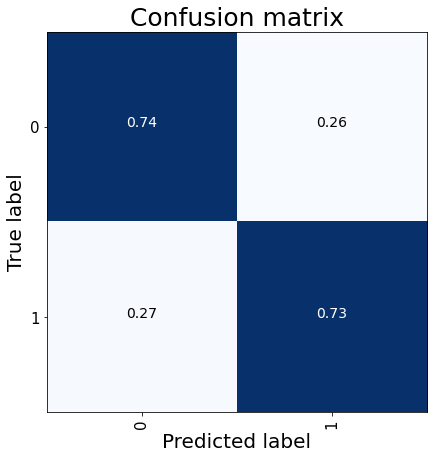

In [25]:
vi.plot_confusion_matrix(y_true=y_test, y_pred=y_pred,labels=y_train.unique())

### Explicando os resultados do modelo através do ranqueamento das features mais importantes para a discriminação dos dados entre as classes

https://machinelearningmastery.com/calculate-feature-importance-with-python/

In [26]:
fig = plt.Figure()
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance

Feature: 0, Score: 0.01339
Feature: 1, Score: 0.00267
Feature: 2, Score: 0.01409
Feature: 3, Score: 0.00953
Feature: 4, Score: 0.00034
Feature: 5, Score: 0.01611
Feature: 6, Score: 0.00279
Feature: 7, Score: 0.01142
Feature: 8, Score: 0.01253
Feature: 9, Score: 0.00061
Feature: 10, Score: 0.00033
Feature: 11, Score: 0.00230
Feature: 12, Score: 0.00277
Feature: 13, Score: 0.00738
Feature: 14, Score: 0.01499
Feature: 15, Score: 0.00213
Feature: 16, Score: 0.00226
Feature: 17, Score: 0.00015
Feature: 18, Score: 0.00233
Feature: 19, Score: 0.00892
Feature: 20, Score: 0.00887
Feature: 21, Score: 0.00413
Feature: 22, Score: 0.00923
Feature: 23, Score: 0.00945
Feature: 24, Score: 0.01311
Feature: 25, Score: 0.00035
Feature: 26, Score: 0.01322
Feature: 27, Score: 0.00159
Feature: 28, Score: 0.00845
Feature: 29, Score: 0.00034
Feature: 30, Score: 0.01019
Feature: 31, Score: 0.00431
Feature: 32, Score: 0.00157
Feature: 33, Score: 0.01051
Feature: 34, Score: 0.00045
Feature: 35, Score: 0.00856
Fe

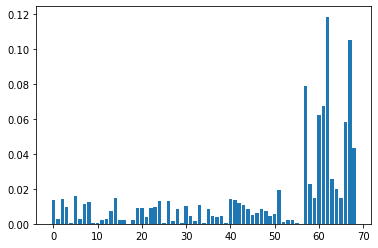

In [27]:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [28]:
df_explain = pd.DataFrame(columns=['feature','importance'])
df_explain['feature'] = X_train.columns
df_explain['importance'] = importance
df_explain_ordered = df_explain.sort_values('importance',ascending=False)
df_explain_ordered.head(10)

feature  importance
62        PESO    0.118682
67  CONSPRENAT    0.105374
57    IDADEMAE    0.079159
61      APGAR5    0.067788
60      APGAR1    0.062552
66  SEMAGESTAC    0.058414
68   MESPRENAT    0.043635
63  QTDGESTANT    0.025447
58  QTDFILVIVO    0.022932
64  QTDPARTNOR    0.019882

In [29]:
filepath = os.path.join(small_data_dir,'rf_model_cardiopatias_congenitas.sav')
io_utils.save_pickle(filepath=filepath,info=clf)

## Verificando o resultado de outros algorítimos por comparação

### Auto Sklearn

In [30]:
automl =  autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=5*60, per_run_time_limit=30, n_jobs=multiprocessing.cpu_count())
automl.fit(X_train, y_train, dataset_name='breast_cancer')
y_pred_automl = automl.predict(X_test)

In [31]:
print(classification_report(y_test, y_pred_automl))


              precision    recall  f1-score   support

           0       0.70      0.72      0.71      3033
           1       0.70      0.68      0.69      2963

    accuracy                           0.70      5996
   macro avg       0.70      0.70      0.70      5996
weighted avg       0.70      0.70      0.70      5996



In [32]:
profiler_data = PipelineProfiler.import_autosklearn(automl)
PipelineProfiler.plot_pipeline_matrix(profiler_data)

### XGBOOST

In [33]:
# fit model no training data
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

/l/disk0/msasso/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[09:41:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
/l/disk0/msasso/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [34]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      3033
           1       0.75      0.75      0.75      2963

    accuracy                           0.75      5996
   macro avg       0.75      0.75      0.75      5996
weighted avg       0.75      0.75      0.75      5996



In [35]:
feature_importances_xgb = xgb_model.get_booster().get_score(importance_type="gain")
feature_importances_xgb

{'APGAR5': 24.85570051297674,
 'PESO': 7.016679150209531,
 'APGAR1': 10.154178389311372,
 'parto_cesareo': 4.590865093417118,
 'stcesparto_ces_antes': 3.5163147021228065,
 '1_3_esc': 7.256231257,
 'IDADEMAE': 4.144070074412554,
 'CONSPRENAT': 13.837682120541253,
 'robson_5': 11.494020631205125,
 'Solteiro': 4.099597374109375,
 'MESPRENAT': 5.488136469406784,
 '4_7_esc': 6.942478150921571,
 'QTDPARTCES': 8.479240332409413,
 'robson_3': 3.5250456519259252,
 'SEMAGESTAC': 4.735161647768018,
 'sttrabpart_nao': 19.84454590668421,
 'raca_mae_branca': 14.089170532280557,
 'grav_unica': 2.7609731975714285,
 'robson_1': 5.896000789535715,
 'raca_parda': 5.592575563292683,
 'robson_11': 10.640724460805556,
 '12_+_esc': 8.76168954669767,
 'tpa_transversa': 2.45996051425,
 'QTDPARTNOR': 4.360306896054347,
 'grav_dupla': 3.0376380958181826,
 'raca_mae_parda': 6.17414557588889,
 'stcesparto_ces_apos': 7.043084809149125,
 'QTDFILVIVO': 3.9617712242430105,
 'sem_esc': 3.5393410031428565,
 'sexo_fem': 

## Fim